In [1]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pmdarima.arima import auto_arima
#from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6


In [2]:
df = pd.read_csv("AirPassengers.csv")
df.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


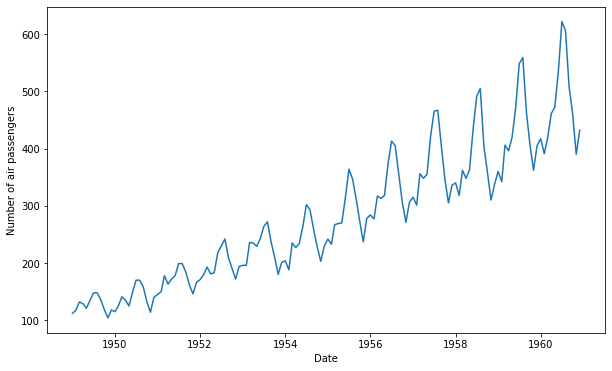

In [4]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

In [5]:
rolmean = df.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


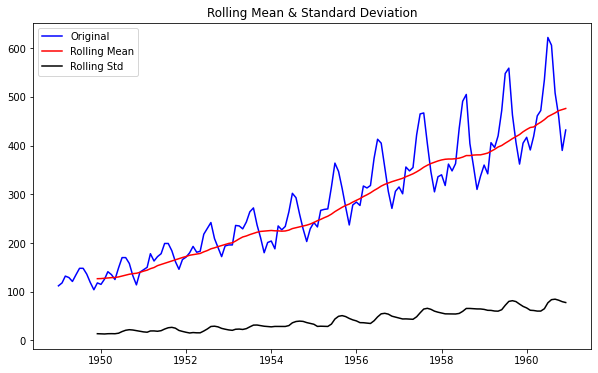

In [6]:
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
print('Results of KPSS Test:')
stat, p, lags, critical_values = kpss(df['#Passengers'], regression="c", nlags="auto")
print(f'Test_statistics: {stat}')
print(f'p_value: {p}')
print(f'Critical_values: {critical_values}')


Results of KPSS Test:
Test_statistics: 1.6513122354165206
p_value: 0.01
Critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [8]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:] 
print(train_data)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1959-08-01          559
1959-09-01          463
1959-10-01          407
1959-11-01          362
1959-12-01          405

[132 rows x 1 columns]


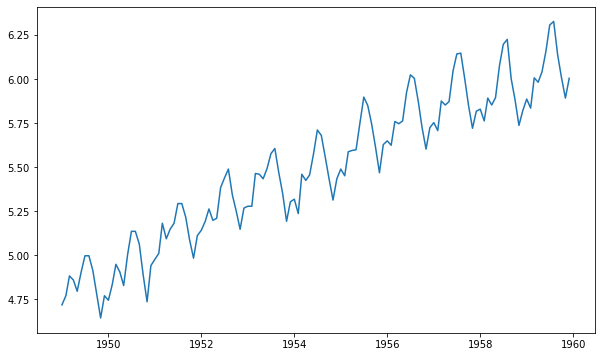

In [10]:
df_log = np.log(train_data)
plt.plot(df_log)

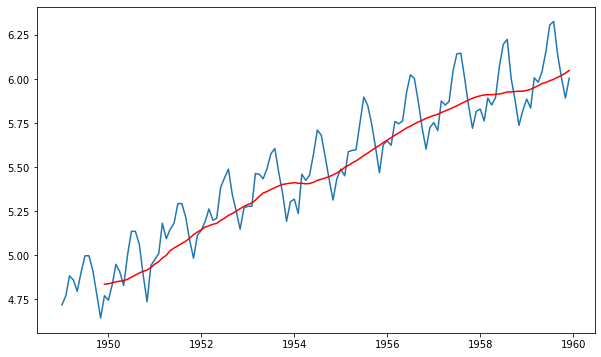

In [11]:
movingAverage = df_log.rolling(window=12).mean()
movingSTD = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(movingAverage, color='red')

In [12]:
'''datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)'''

'datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage\ndatasetLogScaleMinusMovingAverage.head(12)\n\n#Remove NAN values\ndatasetLogScaleMinusMovingAverage.dropna(inplace=True)\ndatasetLogScaleMinusMovingAverage.head(10)'

In [13]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #KPSS test
    print('Results of KPSS Test:')
    stat, p, lags, critical_values = kpss(timeseries['#Passengers'], regression="c", nlags="auto")
    print(f'Test_statistics: {stat}')
    print(f'p_value: {p}')
    print(f'Critical_values: {critical_values}')

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
'''test_stationarity(datasetLogScaleMinusMovingAverage)'''

'test_stationarity(datasetLogScaleMinusMovingAverage)'

In [15]:
'''exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')'''

"exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()\nplt.plot(indexedDataset_logScale)\nplt.plot(exponentialDecayWeightedAverage, color='red')"

In [16]:
'''datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)'''

'datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage\ntest_stationarity(datasetLogScaleMinusExponentialMovingAverage)'

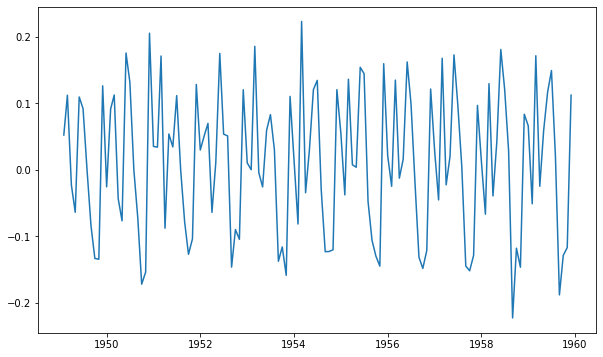

In [17]:
df_log1 = df_log.diff()
plt.plot(df_log1)

In [18]:
print(df_log1)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01     0.052186
1949-03-01     0.112117
1949-04-01    -0.022990
1949-05-01    -0.064022
...                 ...
1959-08-01     0.019874
1959-09-01    -0.188422
1959-10-01    -0.128914
1959-11-01    -0.117169
1959-12-01     0.112243

[132 rows x 1 columns]


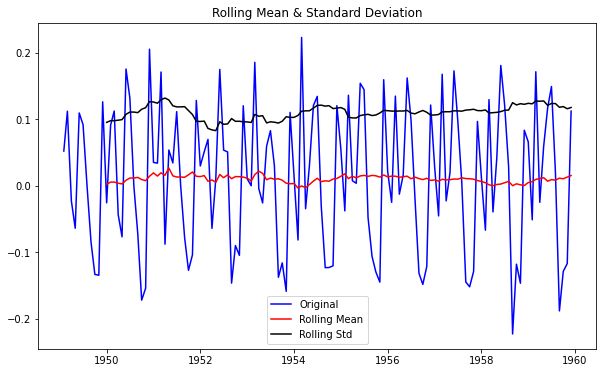

Results of KPSS Test:
Test_statistics: 0.01984396548644912
p_value: 0.1
Critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Results of Dickey Fuller Test:
Test Statistic                  -3.064713
p-value                          0.029277
#Lags Used                      13.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
df_log1.dropna(inplace=True)
test_stationarity(df_log1)

In [20]:
restored = df_log1.cumsum().fillna(0) + df_log.iloc[0]
print(restored)

            #Passengers
Month                  
1949-02-01     4.770685
1949-03-01     4.882802
1949-04-01     4.859812
1949-05-01     4.795791
1949-06-01     4.905275
...                 ...
1959-08-01     6.326149
1959-09-01     6.137727
1959-10-01     6.008813
1959-11-01     5.891644
1959-12-01     6.003887

[131 rows x 1 columns]


In [21]:
df_log.iloc[-1]

#Passengers    6.003887
Name: 1959-12-01 00:00:00, dtype: float64

In [22]:
df_log

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1959-08-01,6.326149
1959-09-01,6.137727
1959-10-01,6.008813


In [23]:
print(df_log1.head())
print(restored.head())
print(df_log.head())

            #Passengers
Month                  
1949-02-01     0.052186
1949-03-01     0.112117
1949-04-01    -0.022990
1949-05-01    -0.064022
1949-06-01     0.109484
            #Passengers
Month                  
1949-02-01     4.770685
1949-03-01     4.882802
1949-04-01     4.859812
1949-05-01     4.795791
1949-06-01     4.905275
            #Passengers
Month                  
1949-01-01     4.718499
1949-02-01     4.770685
1949-03-01     4.882802
1949-04-01     4.859812
1949-05-01     4.795791


In [24]:
##This is very much important because it tells how to inverse the data from stationary to normal 
series = pd.Series([1, 2, 1, 4, 5, 6, 4, 8])
diff = series.diff()
print(diff)
restored = diff.cumsum().fillna(0) + series.iloc[0]
print(series.values == restored.values) 
print(restored.values)

0    NaN
1    1.0
2   -1.0
3    3.0
4    1.0
5    1.0
6   -2.0
7    4.0
dtype: float64
[ True  True  True  True  True  True  True  True]
[1. 2. 1. 4. 5. 6. 4. 8.]


            #Passengers
Month                  
1949-07-01    -0.046967
1949-08-01    -0.043050
1949-09-01     0.001023
1949-10-01     0.003311
1949-11-01     0.007125
...                 ...
1959-02-01    -0.048838
1959-03-01    -0.026793
1959-04-01    -0.019719
1959-05-01     0.024473
1959-06-01     0.002231

[120 rows x 1 columns]


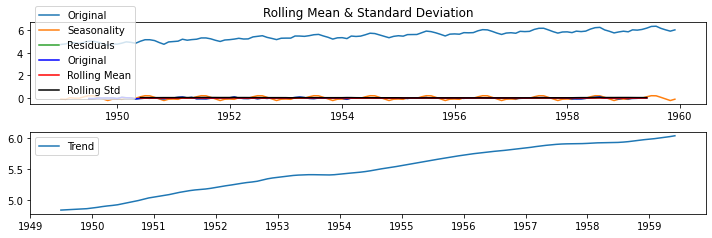

Results of KPSS Test:
Test_statistics: 0.028178307316554026
p_value: 0.1
Critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Results of Dickey Fuller Test:
Test Statistic                -6.914100e+00
p-value                        1.191663e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [25]:
decomposition = seasonal_decompose(df_log) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()



#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData = pd.DataFrame(decomposedLogData)
decomposedLogData.dropna(inplace=True)
decomposedLogData.rename(columns = {'resid' : '#Passengers'}, inplace = True)
print(decomposedLogData)
test_stationarity(decomposedLogData)

            #Passengers
Month                  
1949-07-01    -0.046967
1949-08-01    -0.043050
1949-09-01     0.001023
1949-10-01     0.003311
1949-11-01     0.007125
...                 ...
1959-02-01    -0.048838
1959-03-01    -0.026793
1959-04-01    -0.019719
1959-05-01     0.024473
1959-06-01     0.002231

[120 rows x 1 columns]


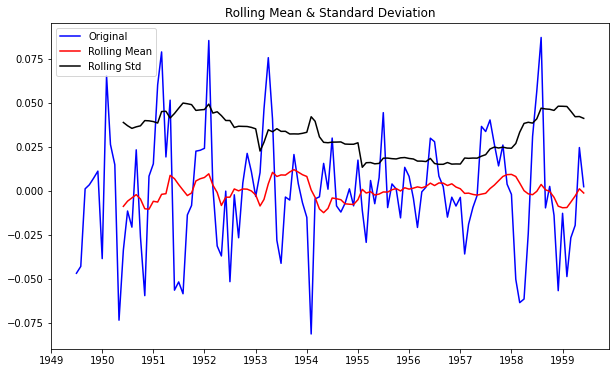

Results of KPSS Test:
Test_statistics: 0.028178307316554026
p_value: 0.1
Critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Results of Dickey Fuller Test:
Test Statistic                -6.914100e+00
p-value                        1.191663e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
decomposedLogData = pd.DataFrame(decomposedLogData)
decomposedLogData.rename(columns = {'resid' : '#Passengers'}, inplace = True)
print(decomposedLogData)
test_stationarity(decomposedLogData)

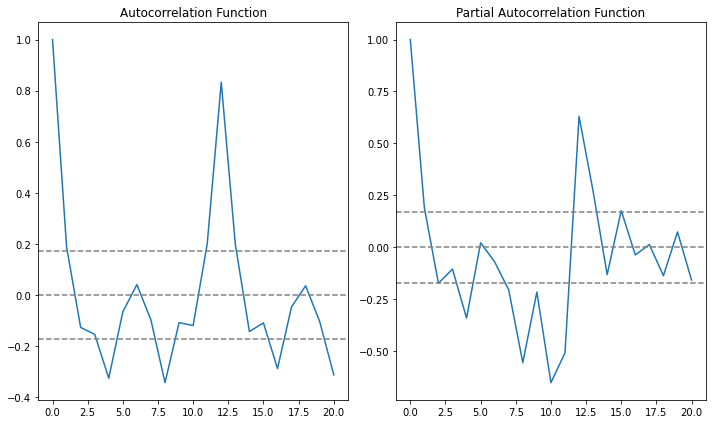

In [27]:
#ACF & PACF plots

lag_acf = acf(df_log1, nlags=20)
lag_pacf = pacf(df_log1, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log1)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log1)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()     

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


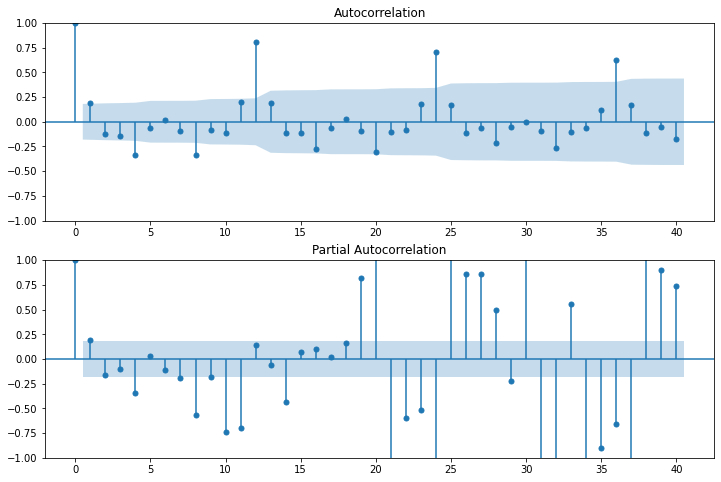

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_log1['#Passengers'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_log1['#Passengers'].iloc[13:],lags=40,ax=ax2)

In [30]:
print(df_log1)

            #Passengers
Month                  
1949-02-01     0.052186
1949-03-01     0.112117
1949-04-01    -0.022990
1949-05-01    -0.064022
1949-06-01     0.109484
...                 ...
1959-08-01     0.019874
1959-09-01    -0.188422
1959-10-01    -0.128914
1959-11-01    -0.117169
1959-12-01     0.112243

[131 rows x 1 columns]


In [31]:
'''from pyramid.arima import auto_arima
stepwise_model = auto_arima(datasetLogScaleMinusExponentialMovingAverage['#Passengers'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
results_ARIMA = stepwise_model.fit(datasetLogScaleMinusExponentialMovingAverage['#Passengers'])'''


"from pyramid.arima import auto_arima\nstepwise_model = auto_arima(datasetLogScaleMinusExponentialMovingAverage['#Passengers'], start_p=1, start_q=1,\n                           max_p=3, max_q=3, m=12,\n                           start_P=0, seasonal=True,\n                           d=1, D=1, trace=True,\n                           error_action='ignore',  \n                           suppress_warnings=True, \n                           stepwise=True)\nprint(stepwise_model.aic())\nresults_ARIMA = stepwise_model.fit(datasetLogScaleMinusExponentialMovingAverage['#Passengers'])"

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting ARIMA model


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


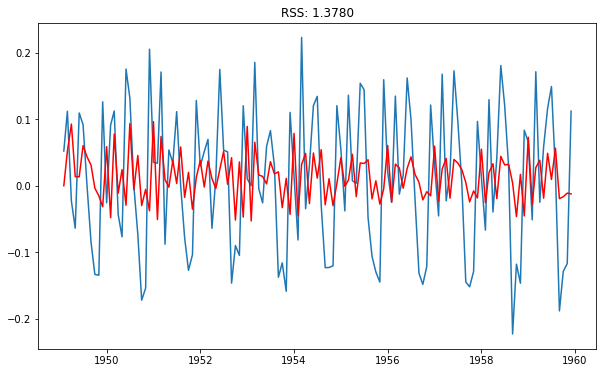

In [32]:
from statsmodels.tsa.arima.model import ARIMA
# AR+I+MA = ARIMA model
model = ARIMA(df_log1['#Passengers'], order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(df_log1)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log1['#Passengers'])**2))
print('Plotting ARIMA model')

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting MA model


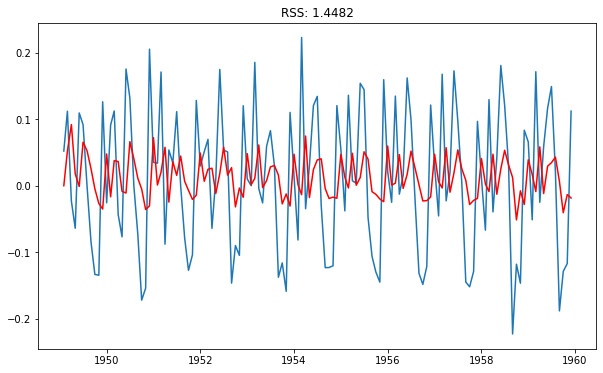

In [33]:
#MA Model
model = ARIMA(df_log1['#Passengers'], order=(0,1,2))
results_MA = model.fit()
plt.plot(df_log1)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - df_log1['#Passengers'])**2))
print('Plotting MA model')

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting AR model


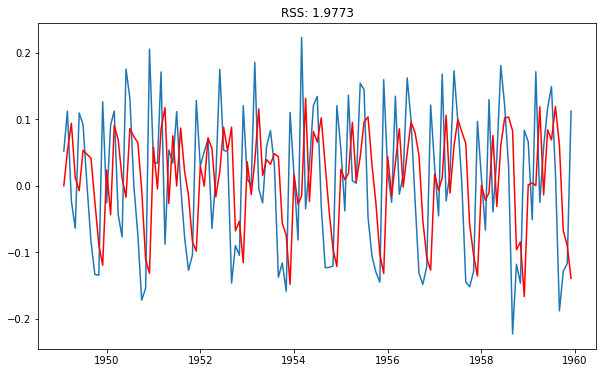

In [34]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(df_log1['#Passengers'], order=(2,1,0))
results_AR = model.fit()
plt.plot(df_log1)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_log1['#Passengers'])**2))
print('Plotting AR model')

In [35]:
#rcParams['figure.figsize']=20,10
#results_ARIMA.plot_diagnostics(1,204)
x=results_ARIMA.forecast(steps=12)

In [36]:
print(x)

1960-01-01    0.053547
1960-02-01   -0.012617
1960-03-01    0.025186
1960-04-01    0.000394
1960-05-01    0.016474
1960-06-01    0.006036
1960-07-01    0.012811
1960-08-01    0.008413
1960-09-01    0.011268
1960-10-01    0.009415
1960-11-01    0.010618
1960-12-01    0.009837
Freq: MS, Name: predicted_mean, dtype: float64


In [37]:
x = pd.DataFrame(x)
print(x)
x.rename(columns = {'predicted_mean' : '#Passengers'}, inplace = True)
print(x)

            predicted_mean
1960-01-01        0.053547
1960-02-01       -0.012617
1960-03-01        0.025186
1960-04-01        0.000394
1960-05-01        0.016474
1960-06-01        0.006036
1960-07-01        0.012811
1960-08-01        0.008413
1960-09-01        0.011268
1960-10-01        0.009415
1960-11-01        0.010618
1960-12-01        0.009837
            #Passengers
1960-01-01     0.053547
1960-02-01    -0.012617
1960-03-01     0.025186
1960-04-01     0.000394
1960-05-01     0.016474
1960-06-01     0.006036
1960-07-01     0.012811
1960-08-01     0.008413
1960-09-01     0.011268
1960-10-01     0.009415
1960-11-01     0.010618
1960-12-01     0.009837


In [38]:
x = x.cumsum().fillna(0) + df_log.iloc[-1]
print(x)

            #Passengers
1960-01-01     6.057435
1960-02-01     6.044818
1960-03-01     6.070004
1960-04-01     6.070398
1960-05-01     6.086872
1960-06-01     6.092908
1960-07-01     6.105719
1960-08-01     6.114133
1960-09-01     6.125401
1960-10-01     6.134816
1960-11-01     6.145434
1960-12-01     6.155271


In [39]:
predictions_ARIMA = np.exp(x)
print(predictions_ARIMA.head())

            #Passengers
1960-01-01   427.277871
1960-02-01   421.920877
1960-03-01   432.682310
1960-04-01   432.852916
1960-05-01   440.042841


In [40]:
print(test_data.head())

            #Passengers
Month                  
1960-01-01          417
1960-02-01          391
1960-03-01          419
1960-04-01          461
1960-05-01          472


In [41]:
y = test_data['#Passengers']
Y = predictions_ARIMA['#Passengers']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

11.323171573523243


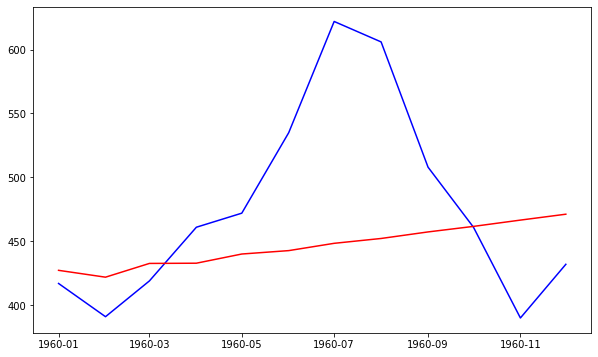

In [42]:
orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')
predicted = plt.plot(predictions_ARIMA['#Passengers'], color='red', label='Predicted')
plt.show(block=False)

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving averag

Plotting SARIMA model


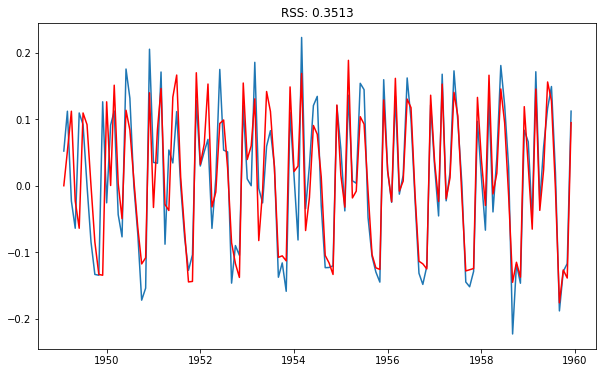

In [43]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_log1['#Passengers'], order=(2,1,2),seasonal_order=(2,1,2,12))
results_SARIMA = model.fit()
plt.plot(df_log1)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_SARIMA.fittedvalues - df_log1['#Passengers'])**2))
print('Plotting SARIMA model')

In [44]:
x=results_SARIMA.forecast(steps=12)
x = pd.DataFrame(x)
print(x)
x.rename(columns = {'predicted_mean' : '#Passengers'}, inplace = True)
print(x)

            predicted_mean
1960-01-01        0.035929
1960-02-01       -0.049048
1960-03-01        0.154553
1960-04-01       -0.027021
1960-05-01        0.041275
1960-06-01        0.145802
1960-07-01        0.129136
1960-08-01        0.013788
1960-09-01       -0.182058
1960-10-01       -0.129084
1960-11-01       -0.128898
1960-12-01        0.105888
            #Passengers
1960-01-01     0.035929
1960-02-01    -0.049048
1960-03-01     0.154553
1960-04-01    -0.027021
1960-05-01     0.041275
1960-06-01     0.145802
1960-07-01     0.129136
1960-08-01     0.013788
1960-09-01    -0.182058
1960-10-01    -0.129084
1960-11-01    -0.128898
1960-12-01     0.105888


In [45]:
x = x.cumsum().fillna(0) + df_log.iloc[-1]
print(x)

            #Passengers
1960-01-01     6.039816
1960-02-01     5.990768
1960-03-01     6.145320
1960-04-01     6.118299
1960-05-01     6.159574
1960-06-01     6.305376
1960-07-01     6.434512
1960-08-01     6.448300
1960-09-01     6.266242
1960-10-01     6.137158
1960-11-01     6.008260
1960-12-01     6.114148


In [46]:
predictions_SARIMA = np.exp(x)
print(predictions_SARIMA.head())

            #Passengers
1960-01-01   419.815724
1960-02-01   399.721303
1960-03-01   466.529049
1960-04-01   454.091708
1960-05-01   473.226478


In [47]:
print(test_data.head())
y = test_data['#Passengers']
Y = predictions_SARIMA['#Passengers']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

            #Passengers
Month                  
1960-01-01          417
1960-02-01          391
1960-03-01          419
1960-04-01          461
1960-05-01          472
2.9774125974905474


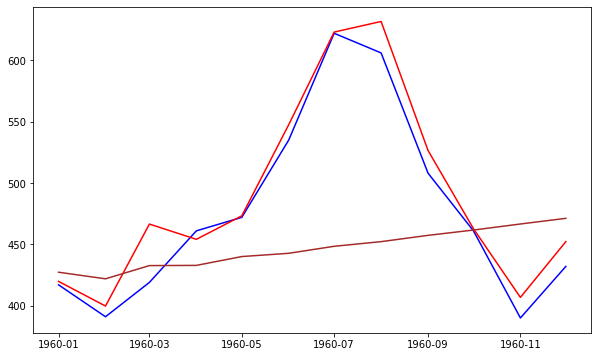

In [48]:
orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')
predicted = plt.plot(predictions_SARIMA['#Passengers'], color='red', label='Predicted')
predicted_ARIMA = plt.plot(predictions_ARIMA['#Passengers'], color='brown', label='Predicted')
plt.show(block=False)

In [49]:
##This is very much important because it tells how to inverse the data from stationary to normal 
series = pd.Series([1, 2, 1, 4, 5, 6, 4, 8])
diff = series.diff()
print(series)
print(diff)
restored = diff.cumsum().fillna(0) + series.iloc[0]
print(series.values == restored.values) 
print(restored.values)

0    1
1    2
2    1
3    4
4    5
5    6
6    4
7    8
dtype: int64
0    NaN
1    1.0
2   -1.0
3    3.0
4    1.0
5    1.0
6   -2.0
7    4.0
dtype: float64
[ True  True  True  True  True  True  True  True]
[1. 2. 1. 4. 5. 6. 4. 8.]


In [50]:
model = auto_arima(df_log1['#Passengers'], start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  131
Model:               SARIMAX(4, 0, 2)   Log Likelihood                 133.486
Date:                Tue, 02 Aug 2022   AIC                           -250.972
Time:                        17:52:54   BIC                           -227.971
Sample:                             0   HQIC                          -241.626
                                - 131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0101      0.002      5.383      0.000       0.006       0.014
ar.L1          0.0423      0.127      0.334      0.739      -0.206       0.291
ar.L2          0.4606      0.120      3.827      0.000       0.225       0.697
ar.L3         -0.2393      0.099     -2.416      0.016      -0.433      -0.045
ar.L4         -0.2441      0.104     -2.350      0.019      -0.448      -0.041
ma.L1         -0.0521      0.086     -0.604      0.546      -0.221       0.117
ma.L2         -0.8559      0.085    -10.060      0.000      -1.023      -0.689
sigma2         0.0075      0.001      5.535      0.000       0.005       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.96
Prob(Q):                              0.99   Prob(JB):                         0.05
Heteroskedasticity (H):               1.04   Skew:                             0.23
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

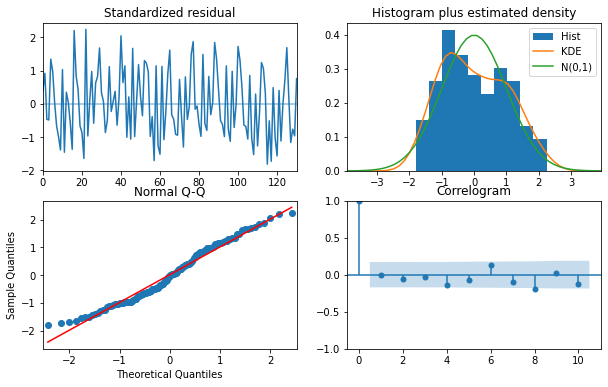

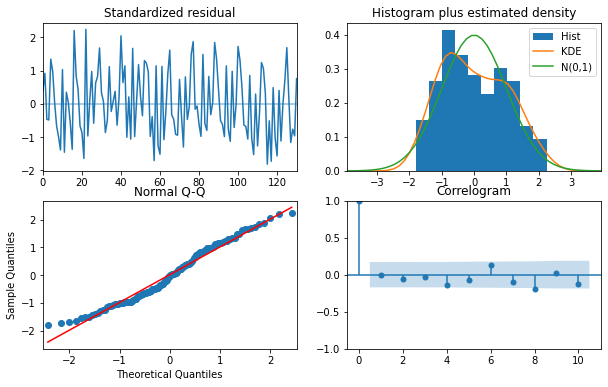

In [51]:
model.plot_diagnostics()

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

Plotting SARIMA model


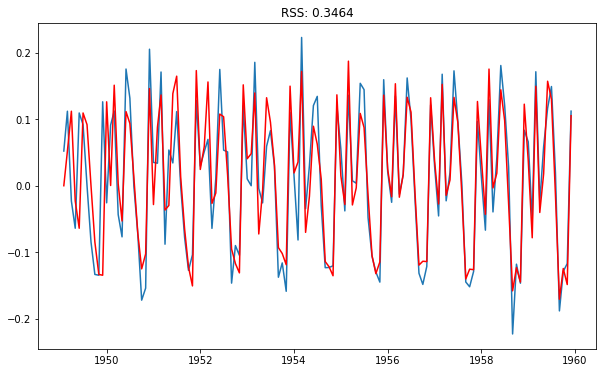

In [53]:
model=sm.tsa.statespace.SARIMAX(df_log1['#Passengers'], order=(4,1,2),seasonal_order=(4,1,2,12))
results_SARIMA = model.fit()
plt.plot(df_log1)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_SARIMA.fittedvalues - df_log1['#Passengers'])**2))
print('Plotting SARIMA model')

In [54]:
x=results_SARIMA.forecast(steps=12)
x = pd.DataFrame(x)
print(x)
x.rename(columns = {'predicted_mean' : '#Passengers'}, inplace = True)
print(x)

            predicted_mean
1960-01-01        0.039647
1960-02-01       -0.052254
1960-03-01        0.149487
1960-04-01       -0.022782
1960-05-01        0.041429
1960-06-01        0.153257
1960-07-01        0.127784
1960-08-01        0.010296
1960-09-01       -0.178016
1960-10-01       -0.131560
1960-11-01       -0.127495
1960-12-01        0.108406
            #Passengers
1960-01-01     0.039647
1960-02-01    -0.052254
1960-03-01     0.149487
1960-04-01    -0.022782
1960-05-01     0.041429
1960-06-01     0.153257
1960-07-01     0.127784
1960-08-01     0.010296
1960-09-01    -0.178016
1960-10-01    -0.131560
1960-11-01    -0.127495
1960-12-01     0.108406


In [55]:
x = x.cumsum().fillna(0) + df_log.iloc[-1]
print(x)
predictions_SARIMA = np.exp(x)
print(predictions_SARIMA.head())

            #Passengers
1960-01-01     6.043534
1960-02-01     5.991280
1960-03-01     6.140767
1960-04-01     6.117985
1960-05-01     6.159415
1960-06-01     6.312671
1960-07-01     6.440456
1960-08-01     6.450752
1960-09-01     6.272735
1960-10-01     6.141175
1960-11-01     6.013680
1960-12-01     6.122086
            #Passengers
1960-01-01   421.379676
1960-02-01   399.926268
1960-03-01   464.409735
1960-04-01   453.949235
1960-05-01   473.151121


In [56]:
print(test_data.head())
y = test_data['#Passengers']
Y = predictions_SARIMA['#Passengers']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

            #Passengers
Month                  
1960-01-01          417
1960-02-01          391
1960-03-01          419
1960-04-01          461
1960-05-01          472
3.312338665972129


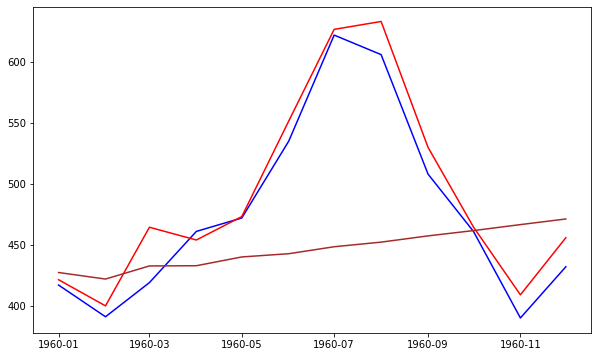

In [57]:
orig = plt.plot(test_data['#Passengers'], color='blue', label='Original')
predicted = plt.plot(predictions_SARIMA['#Passengers'], color='red', label='Predicted')
predicted_ARIMA = plt.plot(predictions_ARIMA['#Passengers'], color='brown', label='Predicted')
plt.show(block=False)